In [12]:
import os

import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def make_contact_distance(traj, cutoff):
    """Calculate the distance matrix every two atom pairs in the molecular dynamics simulation
    Loop through all the atom pairs in trajectory
    agrs:
        traj (mdtraj.Trajectory): trajectory object
    returns:
        contact_map (pandas.DataFrame): contact map of the distances
    """
    contact_map = []
    for i in range(0, traj.n_residues):
        dist = md.compute_distances(traj, [[i, 56]])
        array = np.asarray(dist[:,0]).astype(float)
        contact = np.where(array < cutoff, 1, 0)
        contacts = np.average(contact)
        contact_map.append(contacts)
    final_map = np.asarray(contact_map).astype(float)
    return final_map

def contact_map(traj, cutoff):
    contact_maps = []
    for i in range(1,57):
        contact_map = []
        for j in range(1,57):
            if i == j:
                contacts = 0
            else:
                dist = md.compute_contacts(traj,[[i,j]])
                array = np.asarray(dist[0]).astype(float)
                distance = np.average(array)
                contact = np.where(array < cutoff, 1, 0)
                contacts = np.average(contact)
            contact_map.append(contacts)
        contact_maps.append(contact_map)
    final_map = np.asarray(contact_maps).astype(float)
    
    return final_map
    

def read_trajectory(pdb, trj):
    """Read a MD trajectory with the pdb and dcd input files.

    Args:
        pdb (_type_): _description_
        traj (mdtraj.Trajectory): trajectory object
    """
    # Load the trajectory
    traj = md.load(trj, top=pdb)
    return traj


def get_best_cutoff(traj):
    """Get the course grained cutoff for the contact map with the minimum difference
    from all atom simulations. All atom simulation is aa_pl_contact.

    Args:
        traj (mdtraj.Trajectory): trajectory object

    Returns:
        diff_min: minimum difference
        index: cutoff that provides minimum difference
    """
    diff_min = 1
    index = 0
    global aa_pl_contact
    for i in range(0, 20):
        contact_map = make_contact_map(traj, i)[0:-1]
        diff = np.sum((aa_pl_contact[1:-1,1] - contact_map)**2)
        if diff< diff_min:
            diff_min = diff
            index = i
    print(diff_min, index)
    return diff_min, index

In [4]:
workdir = '/home/daisy/Documents/Research/CG_model/AR_sim/R2_R3/300_original/'
pdb = 'final_system_state.pdb'
trj_file = 'R2_R3_300_TRP_report.dcd'
trj = read_trajectory(workdir+pdb, workdir+trj_file)
top = trj.topology

# for atom in top.atoms:
#     print(atom.name, atom.residue.name, atom.residue.index)
print(trj.n_residues)

57


In [5]:
aa_pl_contact = np.loadtxt('/home/daisy/Documents/Research/AR_Paper/Trajectory_Files_12.20.21_data/R2_R3_epi002/contact.be.pyblock.dat')
residue_index = aa_pl_contact[1:-1, 0]

In [10]:
small_diff, best_cutoff = get_best_cutoff(trj)
contact_distance = make_contact_distance(trj, best_cutoff)[0:-1]
contact_map = contact_map(trj, best_cutoff)

0.04784093490065181 5


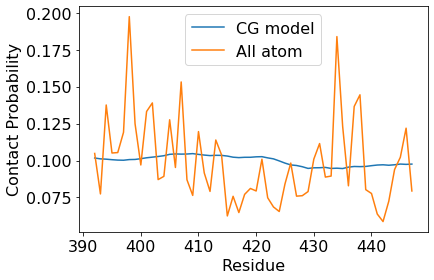

In [7]:
plt.plot(residue_index, contact_distance, label = 'CG model')
plt.plot(residue_index, aa_pl_contact[1:-1,1], label = 'All atom')
plt.legend(fontsize = 16)
plt.xlabel('Residue', size=16)
plt.ylabel('Contact Probability', size=16)
plt.tick_params(labelsize=16)
plt.tight_layout()


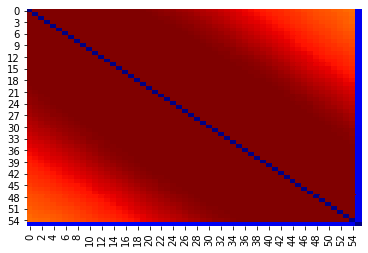

In [14]:
im = sns.heatmap(contact_map, cmap = 'jet', cbar = False)